Tiffany Kashima
STP494
Homework 5

In [486]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import math

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import pydotplus
from IPython.display import Image
from sklearn import tree
import os

In [487]:
rdm= 123

In [488]:
def rmse(target, predictions):
    return np.sqrt((target - predictions)**2)

In [489]:
df = pd.read_csv("/Users/tk/ASU/STP494/data/susedcars.csv")
df.head()

,price,trim,isOneOwner,mileage,year,color,displacement
0,43995,550,f,36858.0,2008,Silver,5.5
1,44995,550,f,46883.0,2012,Black,4.6
2,25999,550,f,108759.0,2007,White,5.5
3,33880,550,f,35187.0,2007,Black,5.5
4,34895,550,f,48153.0,2007,Black,5.5


### Problem 1

In [490]:
X, y = df['mileage'].to_numpy().reshape(-1, 1), df['price'].to_numpy().ravel()

In [491]:
trainX, testX, trainy, testy = train_test_split(X,y,test_size=.3,random_state=rdm, shuffle=True)

In [492]:
tr = DecisionTreeRegressor(max_leaf_nodes=10, random_state=rdm)
tr.fit(trainX,trainy)
yhat = tr.predict(trainX)

In [493]:
print(f'RMSE of Decision Tree in-sample is: {rmse(trainy,yhat).mean()}')
print(f'R2 of Decision Tree in-sample is: {r2_score(trainy,yhat)}')

RMSE of Decision Tree in-sample is: 7171.123679388816
R2 of Decision Tree in-sample is: 0.7492151642050153


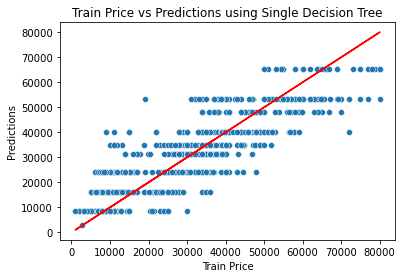

Number of bottom  nodes:  10


In [494]:
sns.scatterplot(x=trainy, y=yhat)
plt.title('Train Price vs Predictions using Single Decision Tree')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()
print("Number of bottom  nodes: ",pd.Series(yhat).nunique())

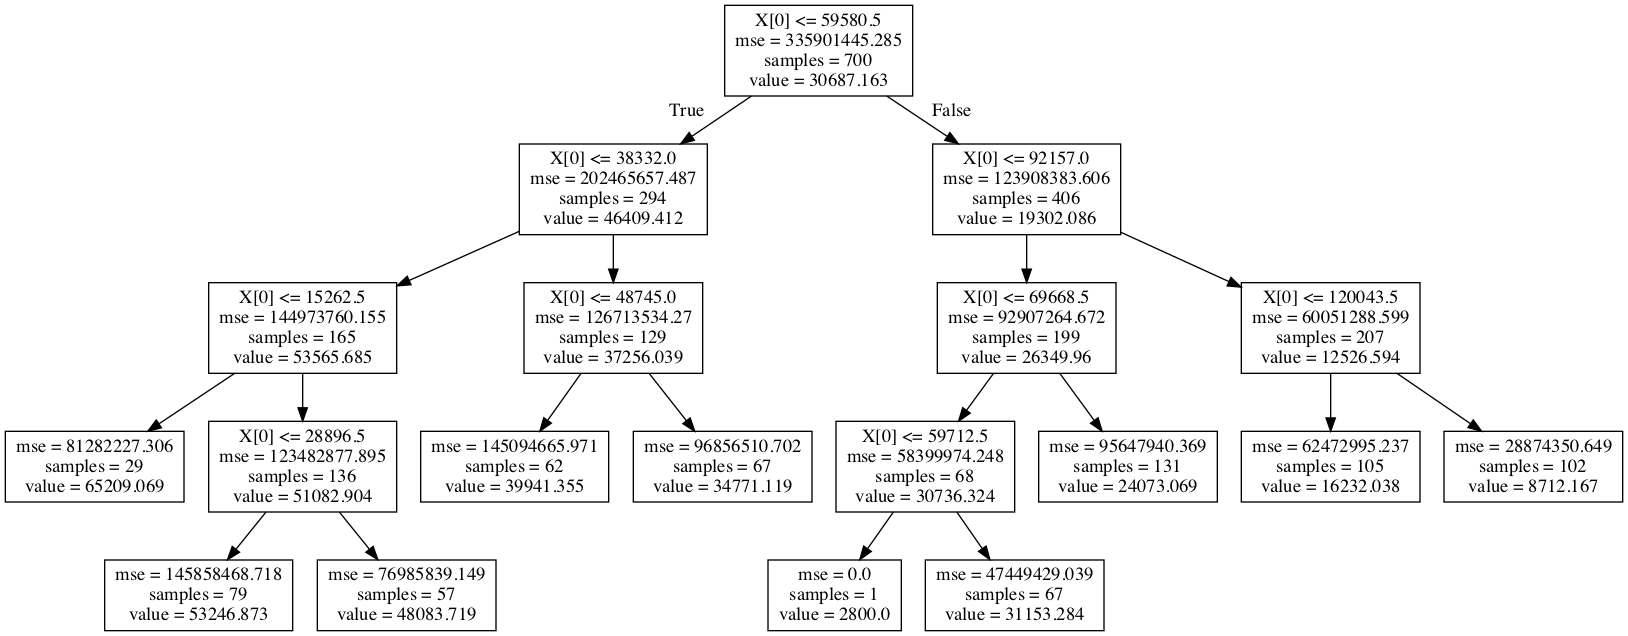

In [495]:
dot_data = tree.export_graphviz(tr, out_file='singletree.dot')
graph = pydotplus.graphviz.graph_from_dot_file('singletree.dot')
Image(graph.create_png())


In [496]:
# Doing Kfold CV on training data, R2 score is consistent
scores = cross_val_score(tr, trainX, trainy, cv=5)
print(f'The average R2 score for 5 fold cross validation in-sample is: {scores.mean()} and the standard deviation is: {scores.std()}')

The average R2 score for 5 fold cross validation in-sample is: 0.6880501082066912 and the standard deviation is: 0.03501660511957126


In [497]:
# Now on test data
yhatte = tr.predict(testX)

In [498]:
print(f'RMSE of Decision Tree out-of-sample is: {rmse(testy,yhatte).mean()}')
print(f'R2 of Decision Tree out-of-sample is: {r2_score(testy,yhatte)}')

RMSE of Decision Tree out-of-sample is: 6778.931299899665
R2 of Decision Tree out-of-sample is: 0.7819388761028339


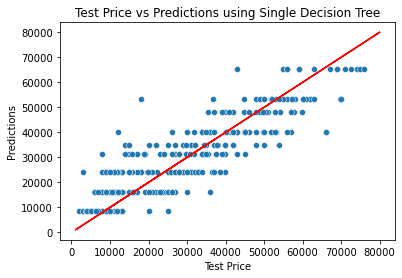

Number of bottom  nodes:  10


In [499]:
# performance is poor on test data
sns.scatterplot(x=testy, y=yhatte)
plt.title('Test Price vs Predictions using Single Decision Tree')
plt.xlabel('Test Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()
print("Number of bottom  nodes: ",pd.Series(yhat).nunique())

In [500]:
# Now with Random Forest

tuning_params = [{'n_estimators':[10,50,100,150]}]
rf = GridSearchCV(RandomForestRegressor(random_state=rdm), tuning_params)
rf.fit(trainX, trainy)

GridSearchCV(estimator=RandomForestRegressor(random_state=123),
             param_grid=[{'n_estimators': [10, 50, 100, 150]}])

In [501]:
print(f"Best Parameter for n_estimators in GridSearchCV is: {rf.best_params_}")
print(f"GridSearchCV best R2 score is: {rf.best_score_}")
print(f"Mean R2 scores from GridSearchCV params are: {rf.cv_results_['mean_test_score']}")
print(f"Standard deviations                          for GridSearchCV params are: {rf.cv_results_['std_test_score']}")

Best Parameter for n_estimators in GridSearchCV is: {'n_estimators': 150}
GridSearchCV best R2 score is: 0.5781064389722594
Mean R2 scores from GridSearchCV params are: [0.56297277 0.5761599  0.57576065 0.57810644]
Standard deviations                          for GridSearchCV params are: [0.05306147 0.04604419 0.04411937 0.04517165]


In [502]:
rftuned = RandomForestRegressor(n_estimators=150, random_state=rdm)
rftuned.fit(trainX, trainy)                         

RandomForestRegressor(n_estimators=150, random_state=123)

In [503]:
yhattr = rftuned.predict(trainX)
print(f"The R2 score for tuned random forest model in-sample is: {r2_score(trainy,yhattr)}")
print(f"The RMSE for the tuned random forest model predictions in-sample is: {rmse(trainy, yhattr).mean()}")

The R2 score for tuned random forest model in-sample is: 0.9473612112023115
The RMSE for the tuned random forest model predictions in-sample is: 3190.504414285714


In [504]:
# Doing Kfold CV on training data
scores_rf = cross_val_score(rftuned, trainX, trainy, cv=5)
print(f'The average R2 score for 5 fold cross validation in-sample is: {scores_rf.mean()} and the standard deviation is: {scores_rf.std()}')

The average R2 score for 5 fold cross validation in-sample is: 0.5781064389722594 and the standard deviation is: 0.045171646465159754


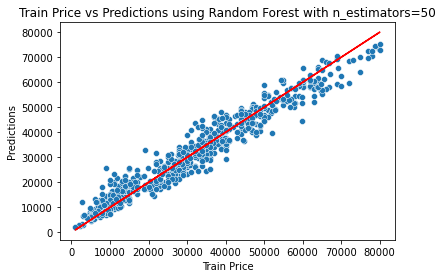

In [505]:
sns.scatterplot(x=trainy, y=yhattr)
plt.title('Train Price vs Predictions using Random Forest with n_estimators=50')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [506]:
# now on test data
yhatte = rftuned.predict(testX)
print(f"The R2 score for tuned random forest model out-sample is: {r2_score(testy,yhatte)}")
print(f"The RMSE for the tuned random forest model predictions out-sample is: {rmse(testy, yhatte).mean()}")

The R2 score for tuned random forest model out-sample is: 0.6840314614314378
The RMSE for the tuned random forest model predictions out-sample is: 8234.617055555556


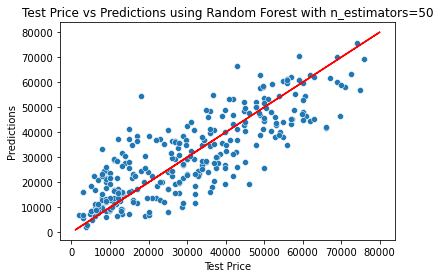

In [507]:
# Performance on test data is poor
sns.scatterplot(x=testy, y=yhatte)
plt.title('Test Price vs Predictions using Random Forest with n_estimators=50')
plt.xlabel('Test Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [508]:
# Boosting with simple hyperparameter tuning

tuning_params = [{'learning_rate':[.1,.2], 'n_estimators':[200,500,1000,2000], 'max_depth':[3,4,5]}]
gb = GridSearchCV(GradientBoostingRegressor(random_state=rdm), tuning_params)
gb.fit(trainX, trainy)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=123),
             param_grid=[{'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5],
                          'n_estimators': [200, 500, 1000, 2000]}])

In [509]:
print(f"Best Parameter for n_estimators in GridSearchCV is: {gb.best_params_}")
print(f"GridSearchCV best R2 score is: {gb.best_score_}")
print(f"Mean R2 scores from GridSearchCV params are: {gb.cv_results_['mean_test_score']}")
print(f"Standard deviations for GridSearchCV params are: {gb.cv_results_['std_test_score']}")

Best Parameter for n_estimators in GridSearchCV is: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
GridSearchCV best R2 score is: 0.6664633335575317
Mean R2 scores from GridSearchCV params are: [0.66646333 0.60593837 0.53679845 0.47625335 0.64229771 0.55597481
 0.4865082  0.45081833 0.59427361 0.50664554 0.46085303 0.44516337
 0.61401782 0.52768761 0.47308336 0.44689064 0.57053982 0.4824445
 0.44965963 0.44404555 0.52752226 0.45865065 0.44489755 0.44388659]
Standard deviations for GridSearchCV params are: [0.02549381 0.03895219 0.05306424 0.06829554 0.02672433 0.04465148
 0.06313563 0.0718342  0.04640604 0.06165518 0.06998407 0.07303197
 0.04048929 0.05539038 0.06676962 0.07241254 0.04259155 0.06535941
 0.07213409 0.07319964 0.05585856 0.07073154 0.07299527 0.0732295 ]


In [510]:
gbtuned = GradientBoostingRegressor(learning_rate=.1, n_estimators=200, max_depth=3, random_state=rdm)
gbtuned.fit(trainX, trainy)

GradientBoostingRegressor(n_estimators=200, random_state=123)

In [511]:
yhattr = gbtuned.predict(trainX)
print(f"The R2 score for tuned Gradient Boosting model in-sample is: {r2_score(trainy,yhattr)}")
print(f"The RMSE for the tuned Gradient Boosting model predictions in-sample is: {rmse(trainy, yhattr).mean()}")

The R2 score for tuned Gradient Boosting model in-sample is: 0.8595706345445735
The RMSE for the tuned Gradient Boosting model predictions in-sample is: 5403.91856549526


In [512]:
# Doing Kfold CV on training data
scores_rf = cross_val_score(gbtuned, trainX, trainy, cv=5)
print(f'The average R2 score for 5 fold cross validation in-sample is: {scores_rf.mean()} and the standard deviation is: {scores_rf.std()}')

The average R2 score for 5 fold cross validation in-sample is: 0.6664633335575317 and the standard deviation is: 0.025493811350579924


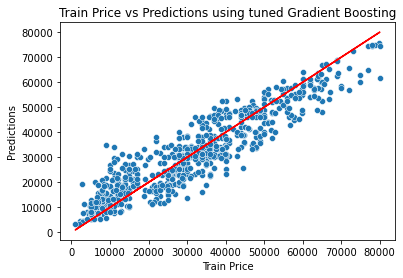

In [513]:

sns.scatterplot(x=trainy, y=yhattr)
plt.title('Train Price vs Predictions using tuned Gradient Boosting')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [514]:
# now on test data
yhatte = gbtuned.predict(testX)
print(f"The R2 score for tuned grandient boosting model out-sample is: {r2_score(testy,yhatte)}")
print(f"The RMSE for the tuned gradient boosting model predictions out-sample is: {rmse(testy, yhatte).mean()}")

The R2 score for tuned grandient boosting model out-sample is: 0.7649928859183626
The RMSE for the tuned gradient boosting model predictions out-sample is: 7098.871639077602


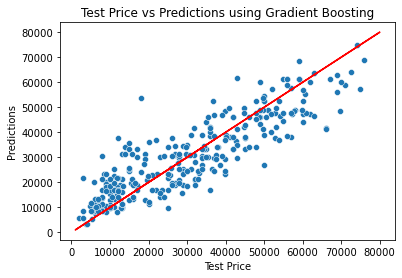

In [515]:
# Performance is improved over random forest but still poor
sns.scatterplot(x=testy, y=yhatte)
plt.title('Test Price vs Predictions using Gradient Boosting')
plt.xlabel('Test Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

## Conclusion

- Gradient Boosting for the single feature dataset for used cars had the best metrics for out of sample performance in comparison to single decision tree and random forest.
- However, performance was poor for all models
- This was not an exhaustive GridSearch over a parameter space for the models.  Scores could be different if this step was further explored.  

### Problem 2

In [516]:
# Now use features: mileage and year
X, y = df.iloc[:,3:5].to_numpy(), df['price'].to_numpy().ravel()


In [517]:
trainX, testX, trainy, testy = train_test_split(X,y,test_size=.3, random_state=rdm, shuffle=True)

In [518]:
feature_labels=['mileage','year']

In [519]:
# First we will do a single tree with the new feature set, 'mileage' and 'year'

tr2 = DecisionTreeRegressor(max_leaf_nodes=10, random_state=rdm)
tr2.fit(trainX,trainy)
yhattr = tr2.predict(trainX)

In [520]:
print(f'RMSE of Decision Tree in-sample is: {rmse(trainy,yhattr).mean()}')
print(f'R2 of Decision Tree in-sample is: {r2_score(trainy,yhattr)}')

RMSE of Decision Tree in-sample is: 4132.819064107409
R2 of Decision Tree in-sample is: 0.901411418544864


In [521]:
# Doing Kfold CV on training data, R2 score is consistent
scores_tree = cross_val_score(tr2, trainX, trainy, cv=5)
print(f'The average R2 score for 5 fold cross validation in-sample is: {scores_tree.mean()} and the standard deviation is: {scores_tree.std()}')

The average R2 score for 5 fold cross validation in-sample is: 0.8692726834047214 and the standard deviation is: 0.02977582961597232


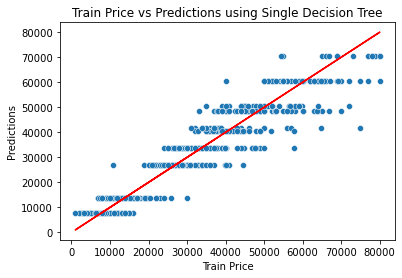

Number of bottom  nodes:  10


In [522]:
sns.scatterplot(x=trainy, y=yhattr)
plt.title('Train Price vs Predictions using Single Decision Tree')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()
print("Number of bottom  nodes: ",pd.Series(yhattr).nunique())

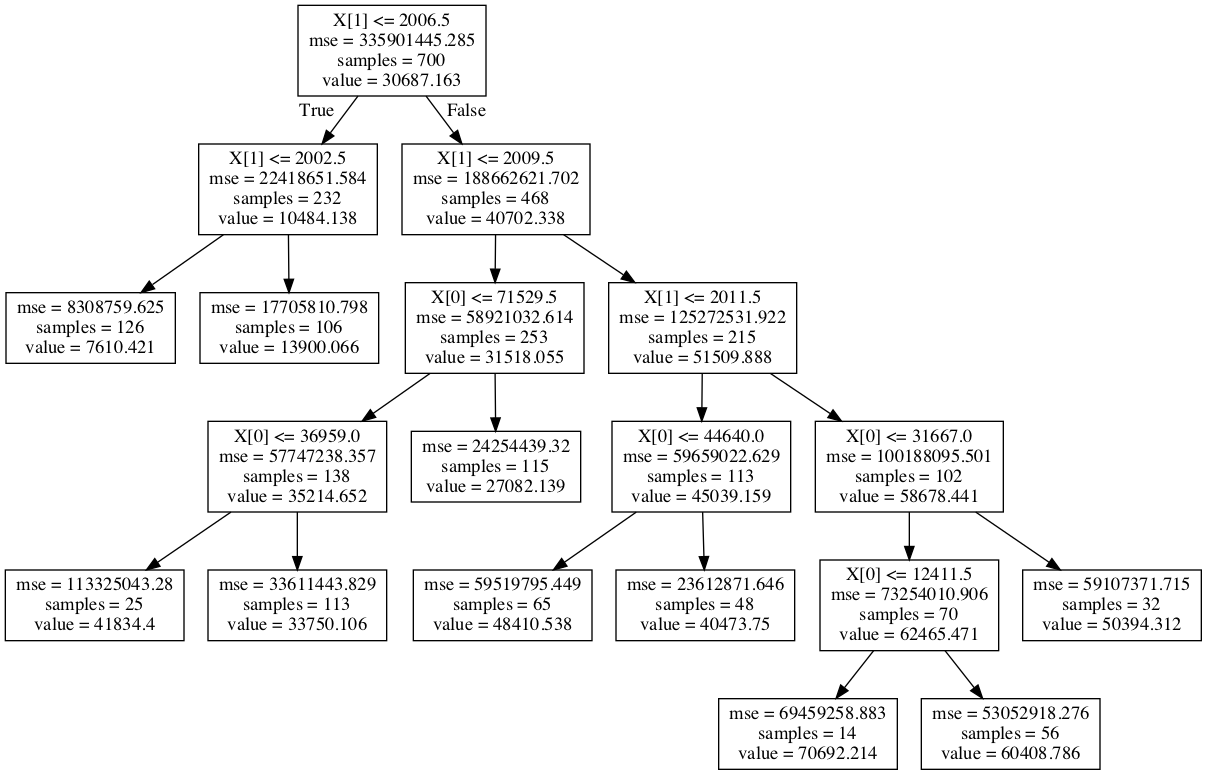

In [523]:
dot_data = tree.export_graphviz(tr2, out_file='singletree.dot')
graph = pydotplus.graphviz.graph_from_dot_file('singletree.dot')
Image(graph.create_png())

In [524]:
# Now on test data
yhatte = tr2.predict(testX)

In [525]:
print(f'RMSE of Decision Tree out-of-sample is: {rmse(testy,yhatte).mean()}')
print(f'R2 of Decision Tree out-of-sample is: {r2_score(testy,yhatte)}')

RMSE of Decision Tree out-of-sample is: 4350.458853449024
R2 of Decision Tree out-of-sample is: 0.8952074749620627


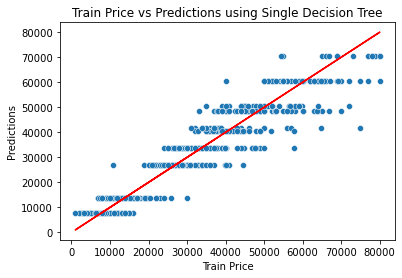

Number of bottom  nodes:  10


In [526]:
sns.scatterplot(x=trainy, y=yhattr)
plt.title('Train Price vs Predictions using Single Decision Tree')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()
print("Number of bottom  nodes: ",pd.Series(yhattr).nunique())

In [527]:
# year is much more important than mileage in our model
varimp = tr2.feature_importances_
print('variable importances:',varimp)
print(pd.Series(tr2.feature_importances_,index=feature_labels))

variable importances: [0.0547779 0.9452221]
mileage    0.054778
year       0.945222
dtype: float64


In [528]:
# train and test performance are not bad with a single decision tree with R2 metrics.  Lets see if we can improve on the RMSE with other learners.

# Random Forest Regression with simple hyperparameter tuning

tuning_params = [{'n_estimators':[10,50,100,150]}]
rf = GridSearchCV(RandomForestRegressor(random_state=rdm), tuning_params)
rf.fit(trainX, trainy)

GridSearchCV(estimator=RandomForestRegressor(random_state=123),
             param_grid=[{'n_estimators': [10, 50, 100, 150]}])

In [529]:
print(f"Best Parameter for n_estimators in GridSearchCV is: {rf.best_params_}")
print(f"GridSearchCV best R2 score is: {rf.best_score_}")
print(f"Mean R2 scores from GridSearchCV params are: {rf.cv_results_['mean_test_score']}")
print(f"Standard deviations                          for GridSearchCV params are: {rf.cv_results_['std_test_score']}")

Best Parameter for n_estimators in GridSearchCV is: {'n_estimators': 50}
GridSearchCV best R2 score is: 0.8843520419173236
Mean R2 scores from GridSearchCV params are: [0.88345506 0.88435204 0.88361971 0.88368991]
Standard deviations                          for GridSearchCV params are: [0.02324103 0.02394291 0.02549869 0.02599038]


In [530]:
rftuned = RandomForestRegressor(n_estimators=50, random_state=rdm)
rftuned.fit(trainX, trainy)                         

RandomForestRegressor(n_estimators=50, random_state=123)

In [531]:
yhattr = rftuned.predict(trainX)
print(f"The R2 score for tuned random forest model in-sample is: {r2_score(trainy,yhattr)}")
print(f"The RMSE for the tuned random forest model predictions in-sample is: {rmse(trainy, yhattr).mean()}")

The R2 score for tuned random forest model in-sample is: 0.9839676500330719
The RMSE for the tuned random forest model predictions in-sample is: 1574.7006285714285


In [532]:
# Doing Kfold CV on training data
scores_rf = cross_val_score(rftuned, trainX, trainy, cv=5)
print(f'The average R2 score for 5 fold cross validation in-sample is: {scores_rf.mean()} and the standard deviation is: {scores_rf.std()}')

The average R2 score for 5 fold cross validation in-sample is: 0.8843520419173236 and the standard deviation is: 0.023942911005139848


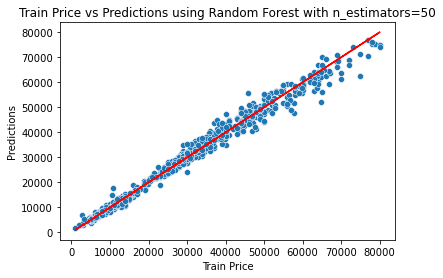

In [533]:
sns.scatterplot(x=trainy, y=yhattr)
plt.title('Train Price vs Predictions using Random Forest with n_estimators=50')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [534]:
# now on test data
yhatte = rftuned.predict(testX)
print(f"The R2 score for tuned random forest model out-sample is: {r2_score(testy,yhatte)}")
print(f"The RMSE for the tuned random forest model predictions out-sample is: {rmse(testy, yhatte).mean()}")

The R2 score for tuned random forest model out-sample is: 0.8980449998111922
The RMSE for the tuned random forest model predictions out-sample is: 4082.1753333333336


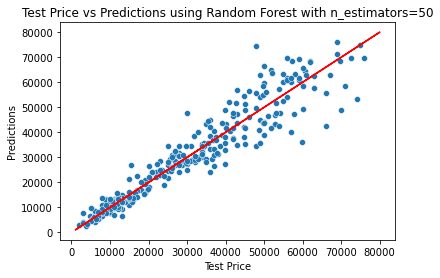

In [535]:
# While the RMSE is improved over single decision tree, there is some fanning past 40,000 suggesting that we may only have accuracy within a restriced domain in out-of sample data
sns.scatterplot(x=testy, y=yhatte)
plt.title('Test Price vs Predictions using Random Forest with n_estimators=50')
plt.xlabel('Test Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [536]:
# feature importances, year is still most importance but mileage contributes more in this model
fimprf = rftuned.feature_importances_
print('variable importances:',fimprf)
print(pd.Series(fimprf, index=feature_labels))

variable importances: [0.17254723 0.82745277]
mileage    0.172547
year       0.827453
dtype: float64


In [537]:
# Boosting with simple hyperparameter tuning

tuning_params = [{'learning_rate':[.1,.2], 'n_estimators':[200,500,1000,2000], 'max_depth':[3,4,5]}]
gb = GridSearchCV(GradientBoostingRegressor(random_state=rdm), tuning_params)
gb.fit(trainX, trainy)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=123),
             param_grid=[{'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5],
                          'n_estimators': [200, 500, 1000, 2000]}])

In [538]:
print(f"Best Parameter for n_estimators in GridSearchCV is: {gb.best_params_}")
print(f"GridSearchCV best R2 score is: {gb.best_score_}")
print(f"Mean R2 scores from GridSearchCV params are: {gb.cv_results_['mean_test_score']}")
print(f"Standard deviations for GridSearchCV params are: {gb.cv_results_['std_test_score']}")

Best Parameter for n_estimators in GridSearchCV is: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
GridSearchCV best R2 score is: 0.8859078514241236
Mean R2 scores from GridSearchCV params are: [0.88590785 0.8712434  0.85685515 0.84885521 0.87892973 0.86162689
 0.85126585 0.84732533 0.87055184 0.85594057 0.85049727 0.84948731
 0.86939468 0.85266216 0.84472809 0.84200422 0.86164008 0.84867628
 0.84521601 0.84482224 0.85274502 0.84583716 0.84495959 0.84492312]
Standard deviations for GridSearchCV params are: [0.03148535 0.03358546 0.03459054 0.03522425 0.02982468 0.02965416
 0.02981831 0.02986538 0.02841391 0.02922022 0.02945925 0.02942986
 0.03119271 0.03500109 0.03596087 0.03631818 0.03245077 0.03258283
 0.03259231 0.03260723 0.02839316 0.02927718 0.02929683 0.02930096]


In [539]:
gbtuned = GradientBoostingRegressor(learning_rate=.1, n_estimators=200, max_depth=3, random_state=rdm)
gbtuned.fit(trainX, trainy)

GradientBoostingRegressor(n_estimators=200, random_state=123)

In [540]:
yhattr = gbtuned.predict(trainX)
print(f"The R2 score for tuned Gradient Boosting model in-sample is: {r2_score(trainy,yhattr)}")
print(f"The RMSE for the tuned Gradient Boosting model predictions in-sample is: {rmse(trainy, yhattr).mean()}")

The R2 score for tuned Gradient Boosting model in-sample is: 0.9676253204820652
The RMSE for the tuned Gradient Boosting model predictions in-sample is: 2342.3030155742886


In [541]:
# Doing Kfold CV on training data
scores_rf = cross_val_score(gbtuned, trainX, trainy, cv=5)
print(f'The average R2 score for 5 fold cross validation in-sample is: {scores_rf.mean()} and the standard deviation is: {scores_rf.std()}')

The average R2 score for 5 fold cross validation in-sample is: 0.8859078514241236 and the standard deviation is: 0.031485349013908


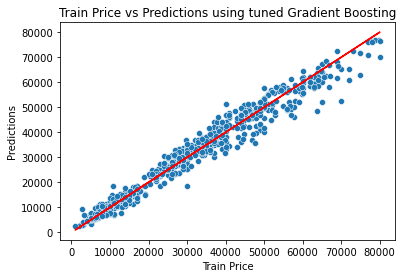

In [542]:
sns.scatterplot(x=trainy, y=yhattr)
plt.title('Train Price vs Predictions using tuned Gradient Boosting')
plt.xlabel('Train Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [543]:
# now on test data
yhatte = gbtuned.predict(testX)
print(f"The R2 score for tuned grandient boosting model out-sample is: {r2_score(testy,yhatte)}")
print(f"The RMSE for the tuned gradient boosting model predictions out-sample is: {rmse(testy, yhatte).mean()}")

The R2 score for tuned grandient boosting model out-sample is: 0.9200364143346316
The RMSE for the tuned gradient boosting model predictions out-sample is: 3589.2858404290955


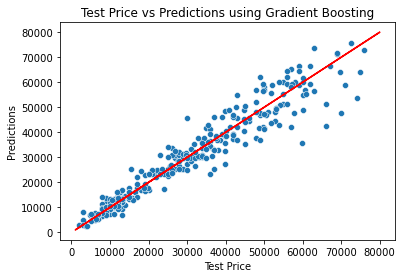

In [544]:
# RMSE is improved over single decision tree and random forest, but still had the same domain problem with prices greater than 40,000 
sns.scatterplot(x=testy, y=yhatte)
plt.title('Test Price vs Predictions using Gradient Boosting')
plt.xlabel('Test Price')
plt.ylabel('Predictions')
plt.plot(trainy,trainy,c='red')
plt.show()

In [545]:
# feature importances, year is still most importance but mileage contributes more in this model
fimpgb = gbtuned.feature_importances_
print('variable importances:',fimpgb)
print(pd.Series(fimpgb, index=feature_labels))

variable importances: [0.19748077 0.80251923]
mileage    0.197481
year       0.802519
dtype: float64


## Conclusion

- Gradient Boosting had the best metrics for out of sample performance in comparison to single decision tree and Random Forest.
- There were domain issues with prices greater than 40,000, where accuracy eroded
- This was not an exhaustive GridSearch over a parameter space for the models.  Scores could be different if this step was further explored.  

### Problem 4

In [627]:
# Using just mileage form dataset
X, y = df['mileage'].to_numpy().reshape(-1, 1), df['price'].to_numpy().ravel()

In [661]:
trainX, testX, trainy, testy = train_test_split(X,y,random_state=rdm, test_size=.3, shuffle=True)

In [629]:
print(f"{trainX.shape}, {trainy.shape}, {testX.shape}, {testy.shape}")

(700, 1), (700,), (300, 1), (300,)


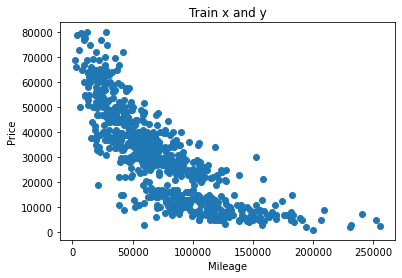

In [630]:
# plot original x and y (training)
plt.scatter(trainX[:,0],trainy)
plt.title('Train x and y')
plt.ylabel('Price')
plt.xlabel('Mileage')
plt.show()

In [631]:
# scale the data with standardization since Neural Nets are sensitive to magnitude (based on linear models)
ss = StandardScaler()
trainX = ss.fit_transform(trainX)
testX = ss.transform(testX)


In [632]:
ssy = StandardScaler()
trainy = ssy.fit_transform(trainy.reshape(-1,1))
testy = ssy.transform(testy.reshape(-1,1))


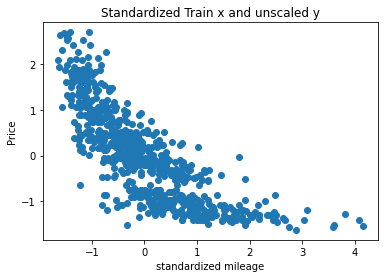

In [633]:
# plot standardized x and y (training), verify we keep important characteristics of dataset
plt.scatter(trainX[:,0],trainy)
plt.title('Standardized Train x and unscaled y')
plt.ylabel('Price')
plt.xlabel('standardized mileage')
plt.show()

In [634]:
# make tensors
class Data(Dataset):
    def __init__(self,X,Y,transform=None,target_transform=None):
        self.X=X
        self.Y=Y
        self.transform = transform
        self.target_transform = target_transform
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return len(self.Y)


In [635]:
# convert to float type with correct dimensions for y
testXX = torch.from_numpy(testX.astype('float32'))
testyy = torch.from_numpy(testy.astype('float32'))
trainyy = torch.from_numpy(trainy.astype('float32'))
trainXX = torch.from_numpy(trainX.astype('float32'))

In [636]:
# data loader
data=Data(trainXX,trainyy)

loader=DataLoader(dataset=data, batch_size=50, shuffle=True)

In [637]:
# check shape and tensors
print(f"{data.X.shape}, {data.X[0:3]}, {data.Y.shape}, {data.Y[0:3]}")

torch.Size([700, 1]), tensor([[2.1054],
        [0.4073],
        [0.7037]]), torch.Size([700, 1]), tensor([[-1.2381],
        [-0.2291],
        [-1.1836]])


In [643]:
# build neural model with mileage and price and sigmoid activation function

class SLNN(torch.nn.Module):
 
    def __init__(self,nunits=5):
        super(SLNN, self).__init__()
        self.SSM = torch.nn.Sequential(
            torch.nn.Linear(1, nunits),
            torch.nn.Sigmoid(),
            torch.nn.Linear(nunits, 1))  
    def forward(self,X):
        yhat = self.SSM(X)
        return yhat

In [644]:
# create model object
nunits=50
model = SLNN(nunits)

In [662]:
# check
model

SLNN(
  (SSM): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [646]:
# train
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_fn(model(dataloader.dataset.X),dataloader.dataset.Y).item()

In [649]:
# define paramters
learning_rate = 1e-3
l2par = .005

In [650]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = l2par)

In [652]:
# epochs
epochs = 2000
lv = np.zeros((epochs,))
for t in range(epochs):
    lv[t] = train_loop(loader, model, loss_fn, optimizer)
print("Complete")

Complete


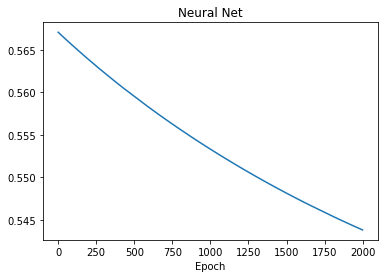

In [653]:
# Plot loss over epochs
plt.plot(np.sqrt(lv))
plt.xlabel('Epoch')
plt.title('Neural Net')
plt.show()

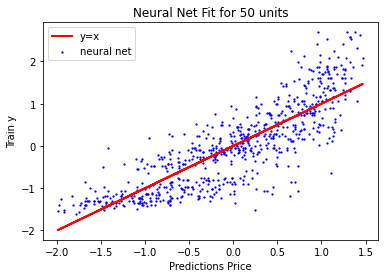

In [654]:
# Plot fit on train data
yyhattr = model(trainXX).detach()
plt.scatter(yyhattr,trainyy,s=1.5,c='blue')
plt.plot(yyhattr,yyhattr,c='red',linewidth=2)
plt.xlabel('Predictions Price')
plt.ylabel('Train y')
plt.title(f'Neural Net Fit for {nunits} units')
plt.legend(['y=x','neural net'])
plt.show()

In [655]:
# now test data
yyhatte = model(testXX).detach().numpy()

print(f"The RMSE for out of sample data is: {rmse(testyy, yyhatte).mean()}")

The RMSE for out of sample data is: 0.3860768973827362


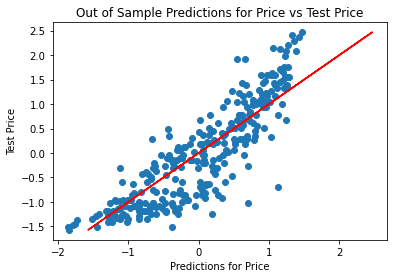

In [656]:
# plot out of sample results
plt.scatter(yyhatte,testyy)
plt.plot(testyy,testyy,c='red')
plt.xlabel('Predictions for Price')
plt.ylabel('Test Price')
plt.title('Out of Sample Predictions for Price vs Test Price')
plt.show()

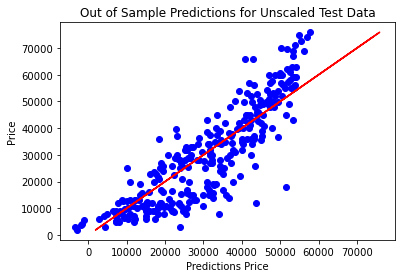

In [659]:
# Show results in original scale (untransformed)
yhatteO = ssy.inverse_transform(yyhatte)
testyyO = ssy.inverse_transform(testyy)

plt.scatter(yhatteO, testyyO,c='blue')
plt.title('Out of Sample Predictions for Unscaled Test Data')
plt.xlabel('Predictions Price')
plt.ylabel('Price')
plt.plot(testyyO, testyyO, c='red')
plt.show()

In [660]:
print(f"The RMSE for out of sample data (original) is: {rmse(testyyO, yhatteO).mean()}")

The RMSE for out of sample data (original) is: 7075.8681640625


### Conclusions
- I tried the neural net model without tranforming y and confirmed that it did not work.  
- Neural net did not outperform any of the other learners with an out of sample RMSE of 7075


### Problem 4

In [670]:
# Using mileage and year from used car dataset
X, y = df.iloc[:,3:5].to_numpy(), df['price'].to_numpy().ravel()

In [671]:
trainX, testX, trainy, testy = train_test_split(X,y,random_state=rdm, test_size=.3, shuffle=True)

In [672]:
print(f"{trainX.shape}, {trainy.shape}, {testX.shape}, {testy.shape}")

(700, 2), (700,), (300, 2), (300,)


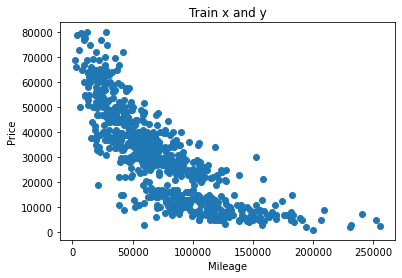

In [674]:
# plot original x=mileage and y (training)
plt.scatter(trainX[:,0],trainy)
plt.title('Train x and y')
plt.ylabel('Price')
plt.xlabel('Mileage')
plt.show()

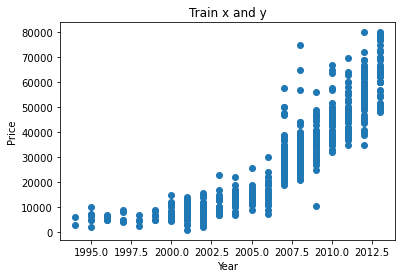

In [675]:
# plot original x=year and y (training)
plt.scatter(trainX[:,1],trainy)
plt.title('Train x and y')
plt.ylabel('Price')
plt.xlabel('Year')
plt.show()

In [676]:
# scale the data with standardization since Neural Nets are sensitive to magnitude (based on linear models)
ss = StandardScaler()
trainX = ss.fit_transform(trainX)
testX = ss.transform(testX)


In [677]:
ssy = StandardScaler()
trainy = ssy.fit_transform(trainy.reshape(-1,1))
testy = ssy.transform(testy.reshape(-1,1))


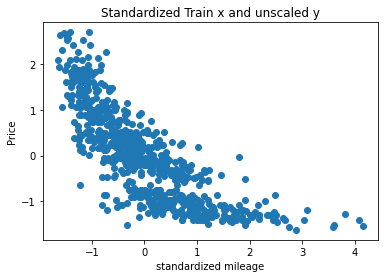

In [678]:
# plot standardized mileage and y (training), verify we keep important characteristics of dataset
plt.scatter(trainX[:,0],trainy)
plt.title('Standardized Train x and unscaled y')
plt.ylabel('Price')
plt.xlabel('standardized mileage')
plt.show()

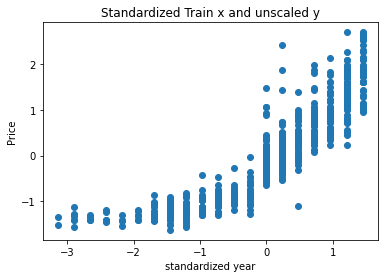

In [679]:
# plot standardized year and y (training), verify we keep important characteristics of dataset
plt.scatter(trainX[:,1],trainy)
plt.title('Standardized Train x and unscaled y')
plt.ylabel('Price')
plt.xlabel('standardized year')
plt.show()

In [680]:
# make tensors
class Data(Dataset):
    def __init__(self,X,Y,transform=None,target_transform=None):
        self.X=X
        self.Y=Y
        self.transform = transform
        self.target_transform = target_transform
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return len(self.Y)


In [681]:
# convert to float type with correct dimensions for y
testXX = torch.from_numpy(testX.astype('float32'))
testyy = torch.from_numpy(testy.astype('float32'))
trainyy = torch.from_numpy(trainy.astype('float32'))
trainXX = torch.from_numpy(trainX.astype('float32'))

In [682]:
# data loader
data=Data(trainXX,trainyy)

loader=DataLoader(dataset=data, batch_size=50, shuffle=True)

In [683]:
# check shape and tensors
print(f"{data.X.shape}, {data.X[0:3]}, {data.Y.shape}, {data.Y[0:3]}")

torch.Size([700, 2]), tensor([[ 2.1054, -1.2055],
        [ 0.4073,  0.2415],
        [ 0.7037, -0.9643]]), torch.Size([700, 1]), tensor([[-1.2381],
        [-0.2291],
        [-1.1836]])


In [684]:
# build neural model with mileage and price and sigmoid activation function

class SLNN(torch.nn.Module):
 
    def __init__(self,nunits=5):
        super(SLNN, self).__init__()
        self.SSM = torch.nn.Sequential(
            torch.nn.Linear(2, nunits),
            torch.nn.Sigmoid(),
            torch.nn.Linear(nunits, 1))  
    def forward(self,X):
        yhat = self.SSM(X)
        return yhat

In [685]:
# create model object
nunits=50
model = SLNN(nunits)

In [686]:
# check
model

SLNN(
  (SSM): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [687]:
# train
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_fn(model(dataloader.dataset.X),dataloader.dataset.Y).item()

In [688]:
# define paramters
learning_rate = 1e-3
l2par = .005

In [689]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = l2par)

In [690]:
# epochs
epochs = 2000
lv = np.zeros((epochs,))
for t in range(epochs):
    lv[t] = train_loop(loader, model, loss_fn, optimizer)
print("Complete")

Complete


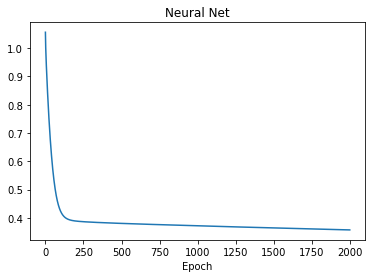

In [691]:
# Plot loss over epochs
plt.plot(np.sqrt(lv))
plt.xlabel('Epoch')
plt.title('Neural Net')
plt.show()

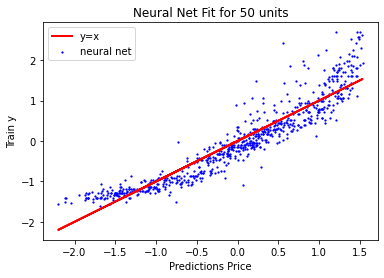

In [692]:
# Plot fit on train data
yyhattr = model(trainXX).detach()
plt.scatter(yyhattr,trainyy,s=1.5,c='blue')
plt.plot(yyhattr,yyhattr,c='red',linewidth=2)
plt.xlabel('Predictions Price')
plt.ylabel('Train y')
plt.title(f'Neural Net Fit for {nunits} units')
plt.legend(['y=x','neural net'])
plt.show()

In [693]:
# now test data
yyhatte = model(testXX).detach().numpy()

print(f"The RMSE for out of sample data is: {rmse(testyy, yyhatte).mean()}")

The RMSE for out of sample data is: 0.2664155662059784


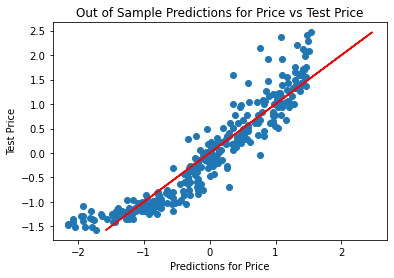

In [694]:
# plot out of sample results
plt.scatter(yyhatte,testyy)
plt.plot(testyy,testyy,c='red')
plt.xlabel('Predictions for Price')
plt.ylabel('Test Price')
plt.title('Out of Sample Predictions for Price vs Test Price')
plt.show()

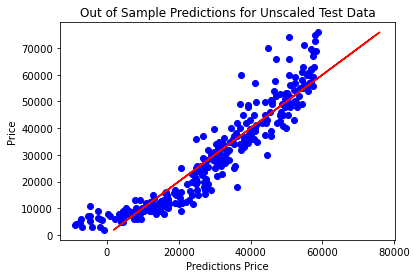

In [695]:
# Show results in original scale (untransformed)
yhatteO = ssy.inverse_transform(yyhatte)
testyyO = ssy.inverse_transform(testyy)

plt.scatter(yhatteO, testyyO,c='blue')
plt.title('Out of Sample Predictions for Unscaled Test Data')
plt.xlabel('Predictions Price')
plt.ylabel('Price')
plt.plot(testyyO, testyyO, c='red')
plt.show()

In [696]:
print(f"The RMSE for out of sample data (original) is: {rmse(testyyO, yhatteO).mean()}")

The RMSE for out of sample data (original) is: 4882.7607421875


### Conclusions
- Neural nets using the same tuning paramters as before with just mileage 
- Neural net with both year and mileage was improved, as expected.  This was the result in the other learners, as well.
- While the RMSE for this nerual net is significantly improved at 4882, it still cannot beat gradiant boosting used with year and mileage.
- Further tuning of the neural net plus using more features could results in better performance.
